# Representation Learning and Property Matching for Thermodynamic Systems

Learn a representation of a thermodynamic system by training a system classifier and use the learned thermodynamic space for property (temperature, ferromagnetic/antiferromagnetic) learning

## Table of Contents

* [1. Data Processing](#1.-Data-Processing)
* [2. Representation Learning](#2.-Representation-Learning)
* [3. Learning and Predicting System Properties](#3.-Learning-and-Predicting-System-Properties)

In [2]:
%matplotlib inline

# basic libraries
import os, sys
import re
import copy
import glob
from itertools import product, combinations
import pickle
from collections import Counter

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from cycler import cycler

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape, ReLU, Softmax
from tensorflow.keras.layers import Lambda, Embedding, LeakyReLU, Conv2D, Conv2DTranspose, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop

import tensorflow_probability as tfp
tfd = tfp.distributions

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# local library for data processing
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_lattice_ising
from statmechlib.preprocessing import Trajectory

sys.path.append('..')
from src.evaluate import get_estimates, plot_ternary, plot_ternary_continuum, plot_spherical, plot_tetrahedron
from src.evaluate import build_feature_extractor, show_filters
from src.evaluate import build_activation_model, show_probs, show_activations
from src.model import trace_loss, variance_loss

In [5]:
# Test gpu availability
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
tf.executing_eagerly()

True

## 1. Data Processing

### Load data from MC simulations

In [7]:
sim_dir = '../sim/mini'
temps = ['t1', 't2', 't5', 't10', 't20', 't100']        # ferromagnetic
temps.extend(['a100', 'a20', 'a10', 'a5', 'a2', 'a1'])  # antiferromagnetic

In [8]:
trjs = {}
for t in temps:
    #print(t)
    traj = read_lattice_ising(os.path.join(sim_dir, t))
    trjs[t] = Trajectory(traj)
    trjs[t] = trjs[t][1:]

print(trjs.keys())
print(len(trjs['t1']['energy']))

dict_keys(['t1', 't2', 't5', 't10', 't20', 't100', 'a100', 'a20', 'a10', 'a5', 'a2', 'a1'])
1000


In [9]:
cfgs = {}
cfgs_pad = {}
for key, trj in trjs.items():
    cfgs[key] = []
    cfgs_pad[key] = []
    for t_cfg, xyz_cfg in zip(trj['atom_type'], trj['xyz_latt']): 
        cfg = np.empty((15, 15), dtype=float)
        for t, (i, j, k) in zip(t_cfg, xyz_cfg):
            cfg[i-1, j-1] = 0.5*(t+1)
        cfgs[key].append(cfg)
        cfgs_pad[key].append(np.pad(cfg, pad_width=((1,1), (1,1)), mode='wrap'))

## Examples of configurations for ferromagnetic (t) and antiferromagnetic (a) Ising models at different reduced temperatures (1 - 100)

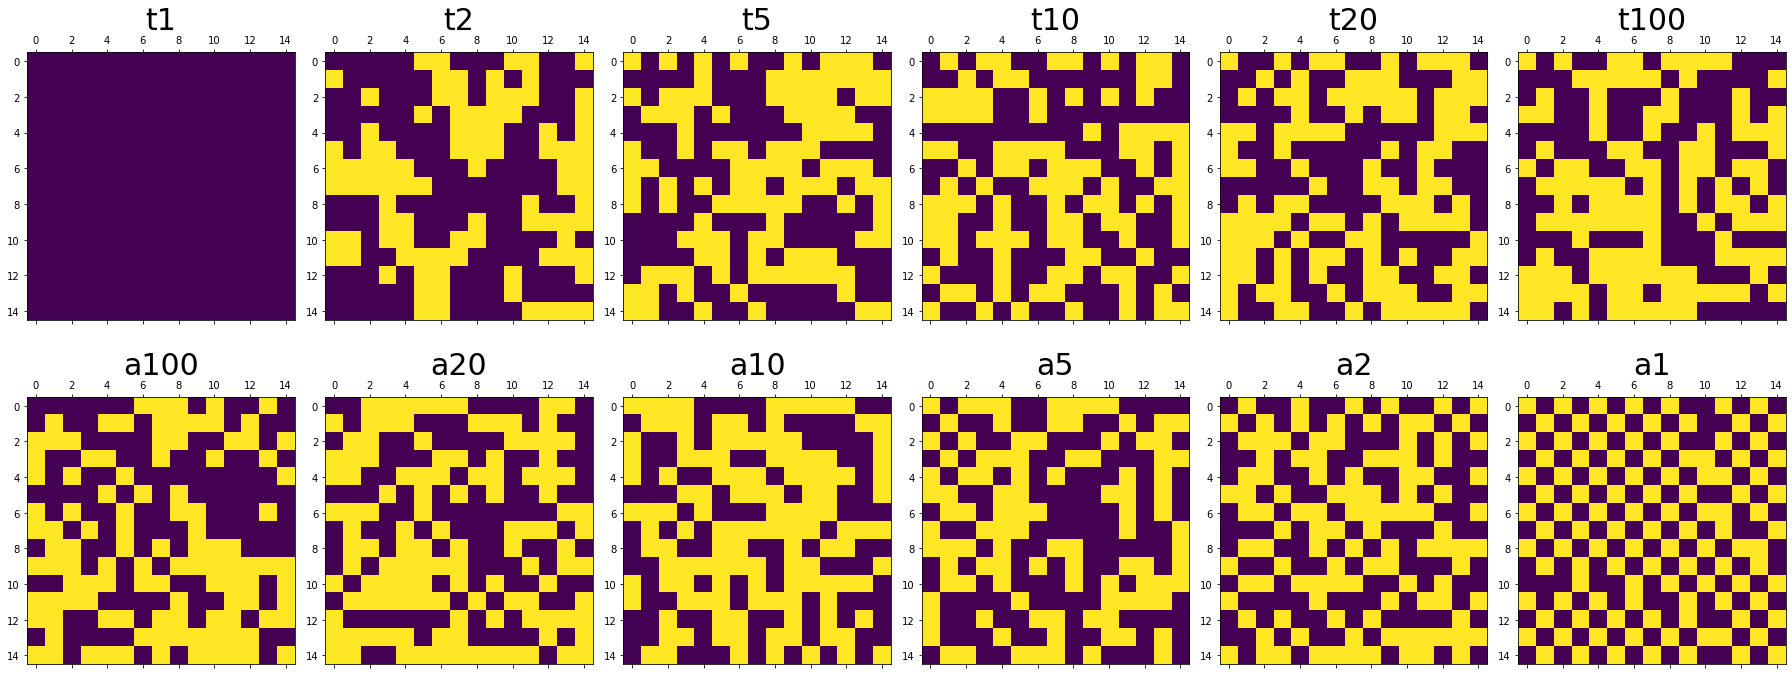

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(25,10))
axs = axs.flatten()
for i, t in enumerate(temps):
    axs[i].set_title(t, fontsize=30)
    axs[i].matshow(cfgs[t][200])

fig.tight_layout()

In [11]:
# Input image dimensions
img_rows, img_cols = cfgs['t1'][0].shape
channels = 1
img_shape = (img_rows, img_cols, channels)

# Dimensions of the embedding space
z_dim = 3

print('Input image shape: ', img_shape)
print('Feature space dimension: ', z_dim)

Input image shape:  (15, 15, 1)
Feature space dimension:  3


## 2. Representation Learning

Discriminate between different Ising systems by embedding each system into a probability space and optimizing classification in this space. Another (better) option is to maximize between-class/within-class variance ratio (as in Fisher/Linear Discriminant Analysis). This would directly optimize statistical distances.

### 2.1 Model definitions

In [12]:
def build_embedding(img_shape, nfilt, ndim, activation='relu'):
    """Model to embed 2D Ising configurations into an ndim-dimensional probability space.
    
    Collect local configurations from 3x3 windows, convert them into n-dimensional features,
    and convert those into a probability vector using average pooling over the whole
    configuration. 
    
    Arguments
    ---------
    img_shape: tuple
        Shape of the input data
    nfilt: int
        Number of filters in the first layer
    ndim: int
        Embedding dimension
    """
    #initializer = tf.keras.initializers.Orthogonal()
    initializer = 'lecun_normal'
    initializer = 'glorot_uniform'

    model = Sequential()
    model.add(Conv2D(nfilt, kernel_size=3, kernel_initializer=initializer, strides=2, padding='valid',
                     input_shape=img_shape))
    model.add(Activation(activation))
    model.add(Conv2D(ndim, kernel_size=1, kernel_initializer=initializer, strides=1, padding='valid'))
    model.add(Softmax())
    # Assuming indpendent local conigurations, create a unit vector for the whole configuration
    model.add(GlobalAveragePooling2D())  
    model.add(Lambda(lambda x: tf.math.sqrt(x)))

    return model

In [13]:
def build_classifier(nclass):
    """Build a simple linear logistic regression classifier on the probability space.
    Setting use_bias=False ensures that the decision boundaries are geodesics on a sphere.
    
    Arguments
    ---------
    nclass: int
        Number of classes
    """

    model = Sequential()
    model.add(Dense(nclass, use_bias=False))
    model.add(Softmax())
    
    return model

In [14]:
def build_discriminator(mdl_embed, mdl_class):
    """Combine embedding and classification modules"""
 
    # Build a complete model
    model = Sequential()
    model.add(mdl_embed)
    model.add(mdl_class)
    
    return model

### 2.2 Training data preparation

In [22]:
# Set up training data
data_list = [np.expand_dims(np.array(cfgs[t][:]), axis=-1) for t in temps]#["t1", "t100", "a1"]]

In [23]:
# Flip half of t1 configurations (to compensate for the low probability of switching between configs)
dd = data_list[0]
dd[:500] = 1 - dd[:500]
data_list[0] = dd

In [24]:
data_train = np.concatenate(data_list, axis=0)
data_train.shape

(12000, 15, 15, 1)

In [25]:
# Set up labels
#data_out = np.concatenate([mm(dat) for dat in data_list], axis=0)
class_list = [np.array(len(cfg)*[i]) for i, cfg in enumerate(data_list)]
labels = np.concatenate(class_list, axis=0)
labels.shape

(12000,)

In [26]:
# Shuffle data
idx = np.random.permutation(len(labels)) # mix them a bit
data_train = data_train[idx]
labels = labels[idx]
labels_tf = tf.convert_to_tensor(labels, dtype=tf.int32)
data_train.shape, labels_tf.shape

((12000, 15, 15, 1), TensorShape([12000]))

### 2.3 Model building, compiling, and training

**Define loss function for representation learning**

In [27]:
# Build embedding
mdl_embed = build_embedding(img_shape, nfilt=8, ndim=3, activation='relu')

# Build classification layers on top of embedding to train the embedder
mdl_class = build_classifier(nclass=len(np.unique(labels)))

# Connect embedding and classification for representation learning
mdl_train = build_discriminator(mdl_embed, mdl_class)

optimizer = RMSprop()

In [28]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
mdl_train.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
history = mdl_train.fit(data_train, labels_tf, batch_size=60, epochs=1000, verbose=1)

Epoch 1/1000
200/200 [==============================] - 1s 2ms/step - loss: 2.5293 - accuracy: 0.0954
Epoch 2/1000
200/200 [==============================] - 0s 2ms/step - loss: 2.4894 - accuracy: 0.2011
Epoch 3/1000
200/200 [==============================] - 0s 2ms/step - loss: 2.4681 - accuracy: 0.1666
Epoch 4/1000
200/200 [==============================] - 0s 2ms/step - loss: 2.4496 - accuracy: 0.1727
Epoch 5/1000
200/200 [==============================] - 0s 2ms/step - loss: 2.4283 - accuracy: 0.2076
Epoch 6/1000
200/200 [==============================] - 0s 2ms/step - loss: 2.3991 - accuracy: 0.2487
Epoch 7/1000
200/200 [==============================] - 0s 2ms/step - loss: 2.3705 - accuracy: 0.2928
Epoch 8/1000
200/200 [==============================] - 0s 2ms/step - loss: 2.3389 - accuracy: 0.3185
Epoch 9/1000
200/200 [==============================] - 0s 2ms/step - loss: 2.3020 - accuracy: 0.3262
Epoch 10/1000
200/200 [==============================] - 0s 2ms/step - loss: 2.263

200/200 [==============================] - 0s 2ms/step - loss: 1.5049 - accuracy: 0.4764
Epoch 81/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.4989 - accuracy: 0.4814
Epoch 82/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.4990 - accuracy: 0.4852
Epoch 83/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.4947 - accuracy: 0.4850
Epoch 84/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.4888 - accuracy: 0.4822
Epoch 85/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.4898 - accuracy: 0.4814
Epoch 86/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.4919 - accuracy: 0.4823
Epoch 87/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.4916 - accuracy: 0.4843
Epoch 88/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.4929 - accuracy: 0.4758
Epoch 89/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.4790 - a

200/200 [==============================] - 0s 2ms/step - loss: 1.3473 - accuracy: 0.5051
Epoch 160/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.3486 - accuracy: 0.5107
Epoch 161/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.3339 - accuracy: 0.5151
Epoch 162/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.3425 - accuracy: 0.5095
Epoch 163/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.3365 - accuracy: 0.5102
Epoch 164/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.3398 - accuracy: 0.5132
Epoch 165/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.3265 - accuracy: 0.5171
Epoch 166/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.3270 - accuracy: 0.5136
Epoch 167/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.3458 - accuracy: 0.5107
Epoch 168/1000
200/200 [==============================] - 0s 2ms/step - loss: 1

200/200 [==============================] - 0s 2ms/step - loss: 1.2471 - accuracy: 0.5404
Epoch 238/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.2462 - accuracy: 0.5382
Epoch 239/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.2394 - accuracy: 0.5382
Epoch 240/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.2479 - accuracy: 0.5358
Epoch 241/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.2508 - accuracy: 0.5325
Epoch 242/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.2419 - accuracy: 0.5335
Epoch 243/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.2405 - accuracy: 0.5369
Epoch 244/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.2489 - accuracy: 0.5353
Epoch 245/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.2362 - accuracy: 0.5353
Epoch 246/1000
200/200 [==============================] - 0s 2ms/step - loss: 1

200/200 [==============================] - 1s 3ms/step - loss: 1.2015 - accuracy: 0.5411
Epoch 316/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.2047 - accuracy: 0.5391
Epoch 317/1000
200/200 [==============================] - 1s 3ms/step - loss: 1.1975 - accuracy: 0.5414
Epoch 318/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.2013 - accuracy: 0.5384
Epoch 319/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.2041 - accuracy: 0.5337
Epoch 320/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.2022 - accuracy: 0.5410
Epoch 321/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1941 - accuracy: 0.5425
Epoch 322/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.2024 - accuracy: 0.5390
Epoch 323/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1921 - accuracy: 0.5411
Epoch 324/1000
200/200 [==============================] - 0s 2ms/step - loss: 1

200/200 [==============================] - 1s 4ms/step - loss: 1.1808 - accuracy: 0.5359
Epoch 394/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1806 - accuracy: 0.5418
Epoch 395/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1647 - accuracy: 0.5461
Epoch 396/1000
200/200 [==============================] - 1s 3ms/step - loss: 1.1744 - accuracy: 0.5427
Epoch 397/1000
200/200 [==============================] - 1s 3ms/step - loss: 1.1743 - accuracy: 0.5359
Epoch 398/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1721 - accuracy: 0.5426
Epoch 399/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1655 - accuracy: 0.5443
Epoch 400/1000
200/200 [==============================] - 1s 4ms/step - loss: 1.1811 - accuracy: 0.5423
Epoch 401/1000
200/200 [==============================] - 1s 4ms/step - loss: 1.1652 - accuracy: 0.5404
Epoch 402/1000
200/200 [==============================] - 1s 4ms/step - loss: 1

200/200 [==============================] - 0s 2ms/step - loss: 1.1645 - accuracy: 0.5401
Epoch 472/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1575 - accuracy: 0.5454
Epoch 473/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1591 - accuracy: 0.5413
Epoch 474/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1480 - accuracy: 0.5473
Epoch 475/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1507 - accuracy: 0.5453
Epoch 476/1000
200/200 [==============================] - 1s 4ms/step - loss: 1.1370 - accuracy: 0.5480
Epoch 477/1000
200/200 [==============================] - 1s 4ms/step - loss: 1.1496 - accuracy: 0.5481
Epoch 478/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1572 - accuracy: 0.5437
Epoch 479/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1628 - accuracy: 0.5442
Epoch 480/1000
200/200 [==============================] - 0s 2ms/step - loss: 1

200/200 [==============================] - 0s 2ms/step - loss: 1.1411 - accuracy: 0.5407
Epoch 550/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1427 - accuracy: 0.5422
Epoch 551/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1368 - accuracy: 0.5449
Epoch 552/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1478 - accuracy: 0.5415
Epoch 553/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1374 - accuracy: 0.5484
Epoch 554/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1424 - accuracy: 0.5420
Epoch 555/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1312 - accuracy: 0.5455
Epoch 556/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1342 - accuracy: 0.5508
Epoch 557/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1497 - accuracy: 0.5429
Epoch 558/1000
200/200 [==============================] - 0s 2ms/step - loss: 1

200/200 [==============================] - 0s 2ms/step - loss: 1.1247 - accuracy: 0.5464
Epoch 628/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1279 - accuracy: 0.5475
Epoch 629/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1273 - accuracy: 0.5497
Epoch 630/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1244 - accuracy: 0.5520
Epoch 631/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1296 - accuracy: 0.5497
Epoch 632/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1277 - accuracy: 0.5467
Epoch 633/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1273 - accuracy: 0.5460
Epoch 634/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1352 - accuracy: 0.5415
Epoch 635/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1324 - accuracy: 0.5434
Epoch 636/1000
200/200 [==============================] - 0s 2ms/step - loss: 1

200/200 [==============================] - 0s 2ms/step - loss: 1.1103 - accuracy: 0.5516
Epoch 706/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1260 - accuracy: 0.5419
Epoch 707/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1069 - accuracy: 0.5540
Epoch 708/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1184 - accuracy: 0.5477
Epoch 709/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1210 - accuracy: 0.5410
Epoch 710/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1148 - accuracy: 0.5519
Epoch 711/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1093 - accuracy: 0.5554
Epoch 712/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1300 - accuracy: 0.5430
Epoch 713/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1011 - accuracy: 0.5597
Epoch 714/1000
200/200 [==============================] - 0s 2ms/step - loss: 1

200/200 [==============================] - 0s 2ms/step - loss: 1.1087 - accuracy: 0.5455
Epoch 784/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1082 - accuracy: 0.5531
Epoch 785/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0996 - accuracy: 0.5556
Epoch 786/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0880 - accuracy: 0.5604
Epoch 787/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0973 - accuracy: 0.5510
Epoch 788/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1037 - accuracy: 0.5527
Epoch 789/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1029 - accuracy: 0.5538
Epoch 790/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1058 - accuracy: 0.5599
Epoch 791/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0963 - accuracy: 0.5523
Epoch 792/1000
200/200 [==============================] - 0s 2ms/step - loss: 1

200/200 [==============================] - 0s 2ms/step - loss: 1.1104 - accuracy: 0.5482
Epoch 862/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1062 - accuracy: 0.5476
Epoch 863/1000
200/200 [==============================] - 1s 3ms/step - loss: 1.1018 - accuracy: 0.5534
Epoch 864/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0940 - accuracy: 0.5555
Epoch 865/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0944 - accuracy: 0.5547
Epoch 866/1000
200/200 [==============================] - 1s 3ms/step - loss: 1.0935 - accuracy: 0.5528
Epoch 867/1000
200/200 [==============================] - 1s 3ms/step - loss: 1.1002 - accuracy: 0.5495
Epoch 868/1000
200/200 [==============================] - 1s 3ms/step - loss: 1.1090 - accuracy: 0.5446
Epoch 869/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1083 - accuracy: 0.5479
Epoch 870/1000
200/200 [==============================] - 0s 2ms/step - loss: 1

200/200 [==============================] - 0s 2ms/step - loss: 1.0893 - accuracy: 0.5538
Epoch 940/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0948 - accuracy: 0.5562
Epoch 941/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0796 - accuracy: 0.5618
Epoch 942/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1073 - accuracy: 0.5499
Epoch 943/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0940 - accuracy: 0.5564
Epoch 944/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1064 - accuracy: 0.5519
Epoch 945/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0947 - accuracy: 0.5579
Epoch 946/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0890 - accuracy: 0.5541
Epoch 947/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0939 - accuracy: 0.5499
Epoch 948/1000
200/200 [==============================] - 0s 2ms/step - loss: 1

### 2.4 Model performance

Text(0.5, 0.98, 'Optimization History')

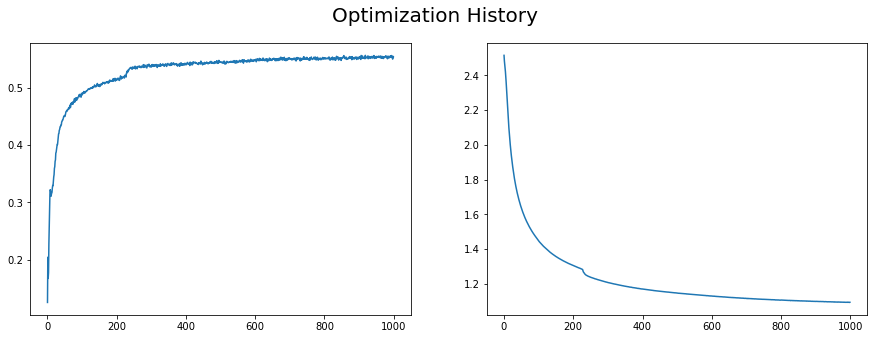

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(history.history['accuracy'])
axs[1].plot(history.history['loss'])
fig.suptitle("Optimization History", fontsize=20)

In [30]:
# Set up training data and lables
data_out = np.concatenate([mdl_embed(dat) for dat in data_list], axis=0)
class_list = [np.array(len(cfg)*[i]) for i, cfg in enumerate(data_list)]
labels_out = np.concatenate(class_list, axis=0)
data_out.shape, labels_out.shape

((12000, 3), (12000,))

In [31]:
if data_out.shape[1] == 2:
    do = data_out[:,0]**2
    dd = np.vstack([do, labels_out]).T
    for c in np.unique(labels_out):
        indx = np.where(dd[:, 1] == c)
        print(np.mean(dd[indx, 0]))

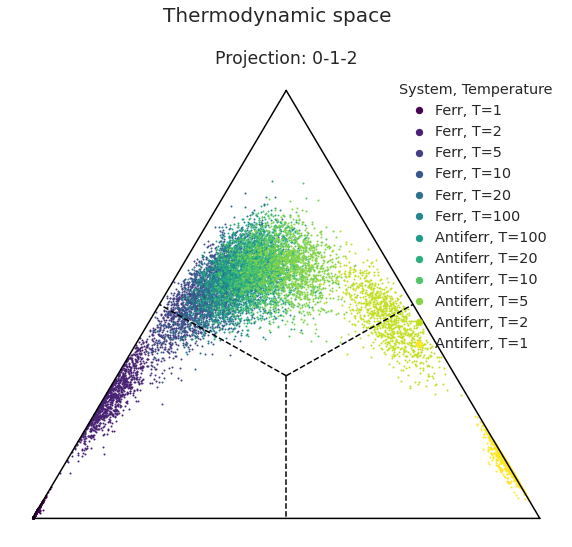

In [33]:
trslt = {'t':'Ferr', 'a':"Antiferr"}
cnames = [f'{trslt[t[0]]}, T={t[1:]}' for t in temps]
plot_ternary(data_out[idx]**2, labels_out[idx], np.unique(labels_out), class_names = cnames, plt_title = "Thermodynamic space",
             size=10)

<IPython.core.display.Javascript object>


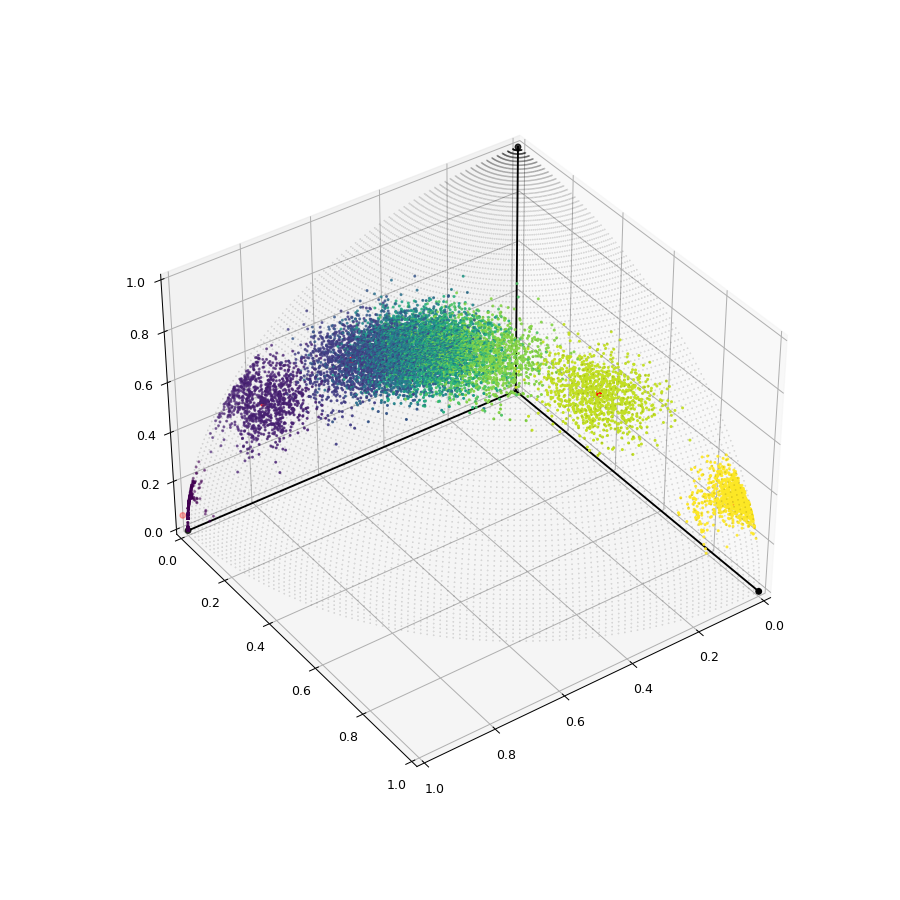

In [34]:
%matplotlib notebook
plot_spherical(data_out, labels_out)

<IPython.core.display.Javascript object>


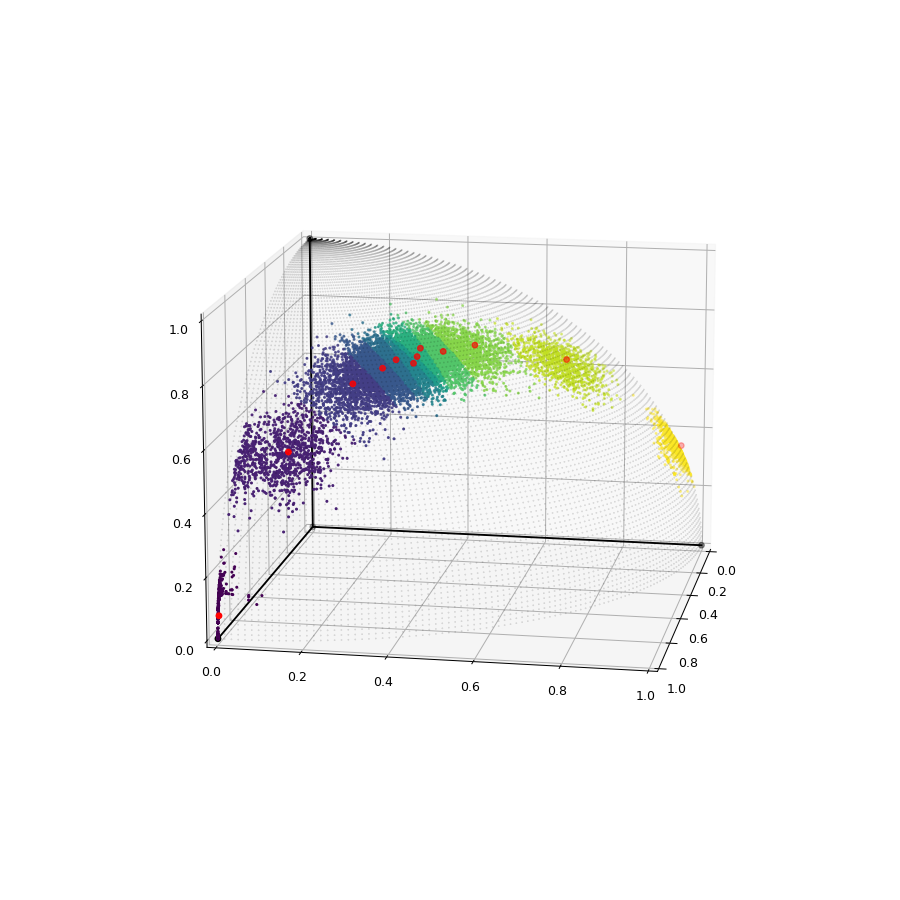

In [35]:
# Predict classes
labels_pred = np.argmax(mdl_train.predict(data_train), axis=1)
#plot_ternary(data_out[idx]**2, labels_pred, np.unique(labels_pred), class_names = cnames, plt_title = "Thermodynamic space",
#             size=10)
plot_spherical(data_out[idx], labels_pred)

<IPython.core.display.Javascript object>


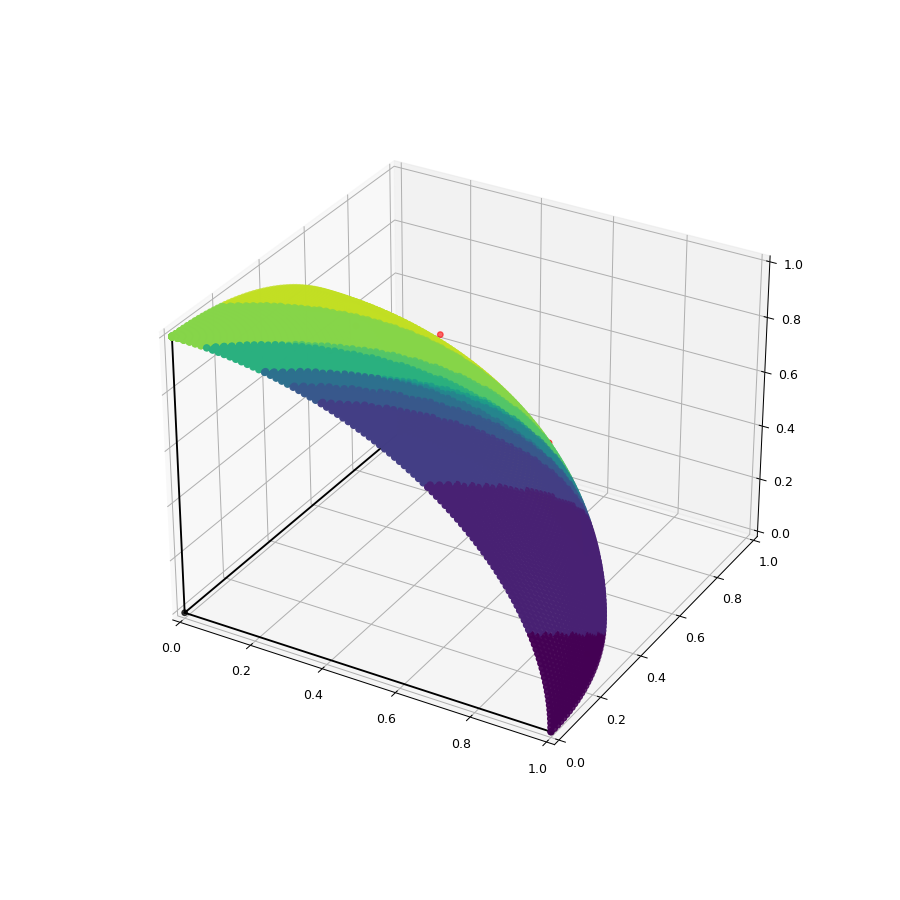

In [37]:
def get_sphere_points():
    phi, theta = np.mgrid[0.0:np.pi/2:100j, 0.0:np.pi/2:100j]
    x = np.sin(phi)*np.cos(theta)
    y = np.sin(phi)*np.sin(theta)
    z = np.cos(phi)
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    data = np.vstack([x, y, z]).T
    return data

points_in = get_sphere_points()
points_pred = np.argmax(mdl_class(points_in), axis=1)
plot_spherical(points_in, points_pred, psize=25)

In [38]:
%matplotlib inline

**Calculate maximum likelihood estimates of multinomial distributions for each class**

In [39]:
out = get_estimates(data_out, labels_out, epochs=1000)

## 3. Learning and Predicting System Properties

Learn mapping between the trained embedding (thermodynamic) space and physical properties

### 3.1 System temperature

#### 3.1.1 Model and its training

In [58]:
def build_temp_prob(nunit):
    """Determine the probability distribution of temperature.
    
    Note that the effect of temperature is indistinguishable from the overall interaction strength.
    
    Arguments:
    ----------
    ndim: int
        dimension of the input embedding space 
        
    Returns:
    --------
    model: tensorflow model
        Model translating a vector in the thermodynamic space into temperature distribution.
    """
    model = Sequential()
    model.add(Lambda(lambda x: tf.math.log(x)))  # from <0, 1> to real
    model.add(Dense(nunit))
    model.add(Activation('relu'))
    model.add(Dense(nunit))
    model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(tfp.layers.DistributionLambda(
        lambda t: tfd.LogNormal(loc=t[..., :1], scale=tf.math.exp(t[..., 1:]))
    ))
    
    return model

In [59]:
def build_temp_layers(nunit):
    """Determine temperature of the system generating given configurations.
    
    Note that the effect of temperature is indistinguishable from the overall interaction strength.
    
    Arguments:
    ----------
    ndim: int
        dimension of the input embedding space 
        
    Returns:
    --------
    model: tensorflow model
        Model translating a vector in the thermodynamic space into temperature.
    """
    model = Sequential()
    model.add(Lambda(lambda x: tf.math.log(x)))  # from <0, 1> to real
    model.add(Dense(nunit))
    model.add(Activation('relu'))
    model.add(Dense(nunit))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Lambda(lambda x: tf.math.exp(x)))  # from real to <0, Inf>
    
    return model

In [60]:
def build_property_learn(mdl_embed, mdl_prop):
 
    mdl_embed.trainable = False

    # Build a complete model
    model = Sequential()
    model.add(mdl_embed)
    model.add(mdl_prop)

    return model

In [61]:
mdl_temp_layers = build_temp_prob(6)
mdl_temp = build_property_learn(mdl_embed, mdl_temp_layers)

In [62]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [63]:
mdl_temp.compile(loss=negloglik, optimizer=Adam())

In [64]:
#mdl_temp.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=['MAE'], optimizer=Adam())

In [65]:
temp_list = [np.array(len(cfg)*[1/float(t[1:])]) for t, cfg in zip(temps, data_list)]
y_temp = np.concatenate(temp_list, axis=0)
y_temp.shape
y_temp = y_temp[idx]

In [66]:
history = mdl_temp.fit(data_train, y_temp, batch_size=240, epochs=100, verbose=1)

Epoch 1/100
50/50 [==============================] - 0s 2ms/step - loss: 1.9074
Epoch 2/100
50/50 [==============================] - 0s 2ms/step - loss: 0.8666
Epoch 3/100
50/50 [==============================] - 0s 2ms/step - loss: 0.4163
Epoch 4/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2933
Epoch 5/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2055
Epoch 6/100
50/50 [==============================] - 0s 2ms/step - loss: 0.1506
Epoch 7/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0683
Epoch 8/100
50/50 [==============================] - 0s 2ms/step - loss: -0.1530
Epoch 9/100
50/50 [==============================] - 0s 2ms/step - loss: -0.3492
Epoch 10/100
50/50 [==============================] - 0s 2ms/step - loss: -0.6020
Epoch 11/100
50/50 [==============================] - 0s 2ms/step - loss: -0.7101
Epoch 12/100
50/50 [==============================] - 0s 2ms/step - loss: -0.7293
Epoch 13/100
50/50 [============

#### 3.1.2 Evaluation and predictions

Text(0.5, 0.98, 'Optimization History')

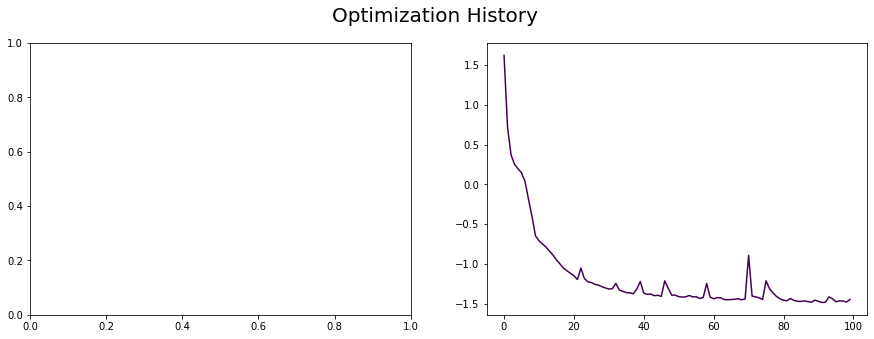

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#axs[0].plot(history.history['MAE'])
axs[1].plot(history.history['loss'])
fig.suptitle("Optimization History", fontsize=20)

In [69]:
y_pred = mdl_temp.predict(data_train)

In [75]:
y_pred

array([[0.00706262],
       [0.55809116],
       [0.00918324],
       ...,
       [0.07837313],
       [0.02040323],
       [0.10649485]], dtype=float32)

In [78]:
t_dist = mdl_temp(data_train)

In [86]:
t_dist

<tfp.distributions.LogNormal 'sequential_12_sequential_11_distribution_lambda_2_LogNormal' batch_shape=[12000, 1] event_shape=[] dtype=float32>

(0.0, 1.5)

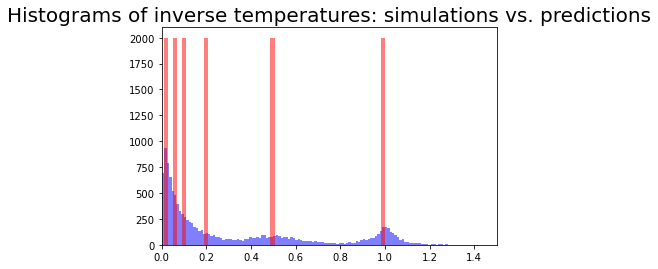

In [88]:
%matplotlib inline
_ = plt.hist(np.ravel(y_pred), color='b', alpha=0.5, bins=500, label="Predicted")
_ = plt.hist(np.ravel(y_temp), color='r', alpha=0.5, bins=50, label="Simulated")
plt.title("Histograms of inverse temperatures: simulations vs. predictions", fontsize=20)
plt.xlim(0, 1.5)

Text(0.5, 1.0, 'Predicted vs. simulated inverse temperature')

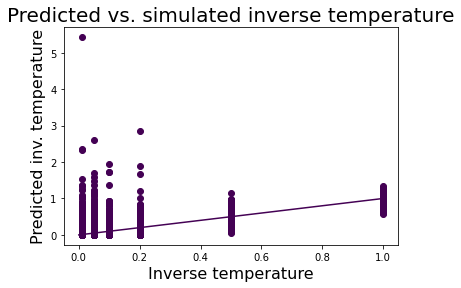

In [89]:
plt.scatter(np.ravel(y_temp), np.ravel(y_pred))
plt.plot([0, 1], [0, 1])
plt.xlabel("Inverse temperature", fontsize=16)
plt.ylabel("Predicted inv. temperature", fontsize=16)
plt.title("Predicted vs. simulated inverse temperature", fontsize=20)

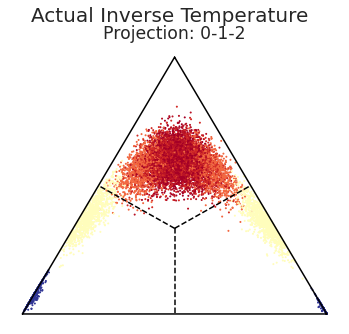

In [139]:
plot_ternary_continuum(data_out[idx]**2, np.ravel(y_temp), size=6, plt_title = "Actual Inverse Temperature")

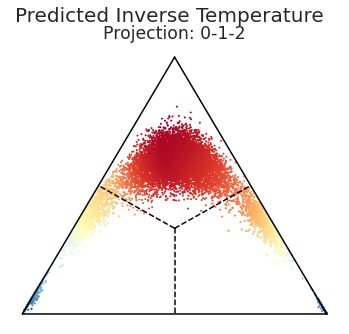

In [140]:
plot_ternary_continuum(data_out[idx]**2, np.ravel(y_pred), size=6, plt_title = "Predicted Inverse Temperature")

### 3.2 System type: Ferromagnetic vs. Antiferromagnetic

#### 3.2.1 Model and its training

In [141]:
def build_system_id_layers(ndim):
    """Classify configurations as coming from ferromagnetic or antiferromagnetic systems
        
    Note that the effect of temperature is indistinguishable from the overall interaction strength.
    
    Arguments:
    ----------
    ndim: int
        dimension of the input embedding space 
        
    Returns:
    --------
    model: tensorflow model
        Model translating a vector in the thermodynamic space into temperature.
    """
       
    model = Sequential()
    model.add(Lambda(lambda x: tf.math.log(x)))
    model.add(Dense(ndim))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [142]:
mdl_sysid_layers = build_system_id_layers(ndim = 4)
mdl_sysid = build_property_learn(mdl_embed, mdl_sysid_layers)

In [143]:
mdl_sysid.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], optimizer=Adam())

In [144]:
sysid_list = [np.array(len(cfg)*[int(t[0] == "a")]) for t, cfg in zip(temps, data_list)]
y_sysid = np.concatenate(sysid_list, axis=0)
y_sysid = np.expand_dims(y_sysid, axis=-1)
y_sysid.shape
y_sysid = y_sysid[idx]

In [145]:
history = mdl_sysid.fit(data_train, y_sysid, epochs=100, verbose=1)

Epoch 1/100
375/375 [==============================] - 1s 2ms/step - loss: 0.5856 - accuracy: 0.7762
Epoch 2/100
375/375 [==============================] - 0s 1ms/step - loss: 0.4655 - accuracy: 0.8486
Epoch 3/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3961 - accuracy: 0.8525
Epoch 4/100
375/375 [==============================] - 1s 1ms/step - loss: 0.3510 - accuracy: 0.8567
Epoch 5/100
375/375 [==============================] - 0s 1ms/step - loss: 0.3198 - accuracy: 0.8598
Epoch 6/100
375/375 [==============================] - 0s 1ms/step - loss: 0.3070 - accuracy: 0.8626
Epoch 7/100
375/375 [==============================] - 0s 1ms/step - loss: 0.3056 - accuracy: 0.8563
Epoch 8/100
375/375 [==============================] - 0s 1ms/step - loss: 0.3045 - accuracy: 0.8508
Epoch 9/100
375/375 [==============================] - 0s 1ms/step - loss: 0.3020 - accuracy: 0.8510
Epoch 10/100
375/375 [==============================] - 0s 1ms/step - loss: 0.2931 - accura

375/375 [==============================] - 0s 1ms/step - loss: 0.2996 - accuracy: 0.8529
Epoch 82/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3011 - accuracy: 0.8507
Epoch 83/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3005 - accuracy: 0.8546
Epoch 84/100
375/375 [==============================] - 1s 2ms/step - loss: 0.2936 - accuracy: 0.8582
Epoch 85/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2933 - accuracy: 0.8608
Epoch 86/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3007 - accuracy: 0.8540
Epoch 87/100
375/375 [==============================] - 1s 2ms/step - loss: 0.2942 - accuracy: 0.8580
Epoch 88/100
375/375 [==============================] - 1s 2ms/step - loss: 0.2901 - accuracy: 0.8575
Epoch 89/100
375/375 [==============================] - 1s 2ms/step - loss: 0.2984 - accuracy: 0.8540
Epoch 90/100
375/375 [==============================] - 1s 1ms/step - loss: 0.3021 - accuracy: 

#### 3.2.2 Evaluation and predictions

In [146]:
# Predict categories: ferromagnetic vs. non-ferromagnetic
y_pred = (np.ravel(mdl_sysid.predict(data_train)) > 0.5).astype(np.int)

idx.shape
print("Confusion matrix")
confusion_matrix(np.ravel(y_sysid), np.ravel(y_pred))

Confusion matrix


array([[5151,  849],
       [ 877, 5123]])

In [147]:
#idx = np.random.permutation(len(correct))  # mix them a bit
correct = (np.ravel(y_sysid) != np.ravel(y_pred)).astype(np.int)

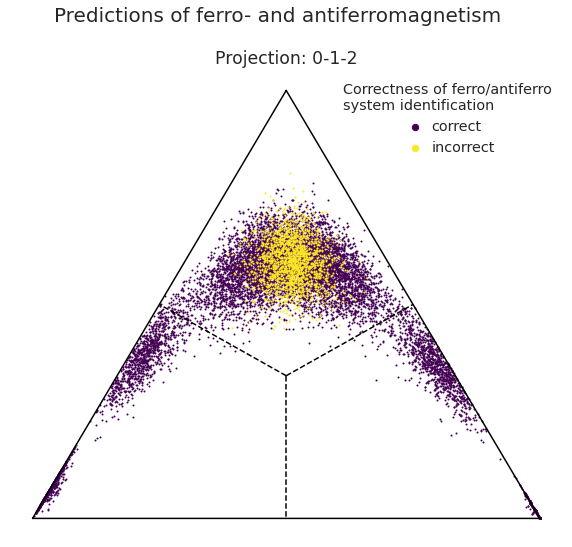

In [148]:
#idx = np.random.permutation(len(correct))  # mix them a bit
plot_ternary(data_out[idx]**2, correct, np.unique(correct), class_names = ["correct", "incorrect"],
             size=10, plt_title = "Predictions of ferro- and antiferromagnetism",
             legend_title = "Correctness of ferro/antiferro\nsystem identification")

## 4. Visualize filters and activations

## Visualize activations

In [152]:
mdl = build_activation_model(mdl_embed)

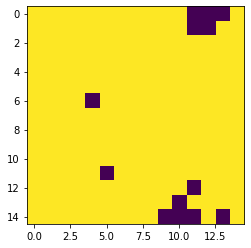

In [154]:
img = cfgs['t1'][60][np.newaxis, :, :, np.newaxis]
plt.imshow(img[0,:,:,0])

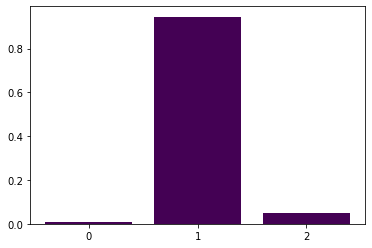

In [155]:
show_probs(img, mdl)

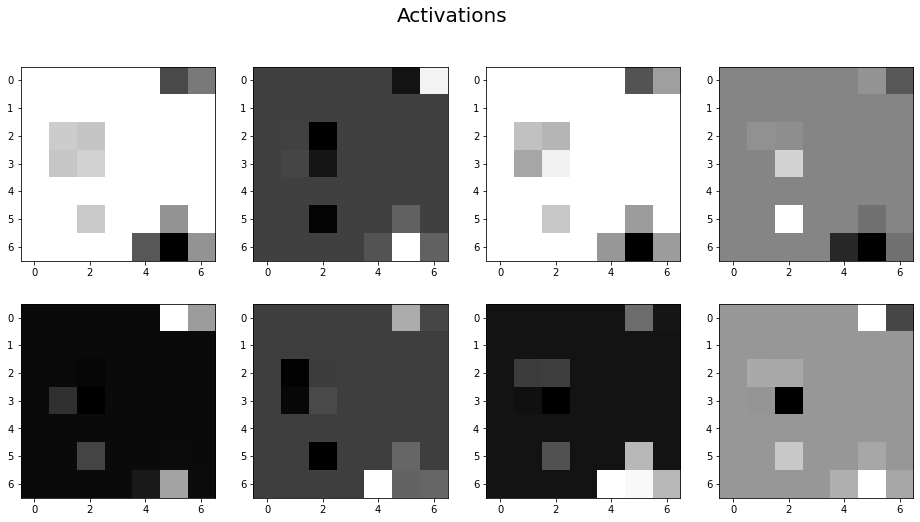

In [156]:
show_activations(img, mdl, layer_num=0, size=4)

### Visualize filters maximizing activation at different layers

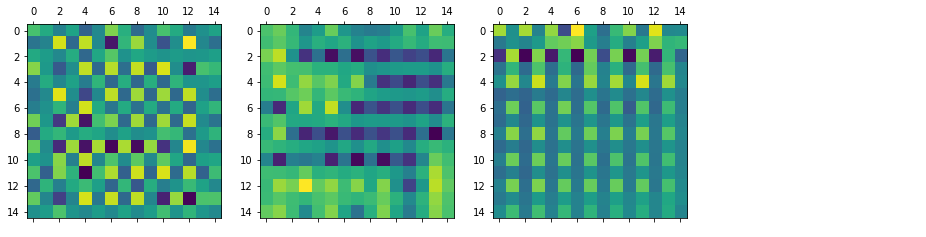

In [160]:
layer_number = 2
feature_extractor = build_feature_extractor(mdl_embed, layer_number=layer_number)
show_filters(nfilt=3, cfg_shape=data_train[0:1].shape, feature_extractor=feature_extractor)
#feature_extractor.summary()